# ML classifier - XGBoost

In [49]:
import xgboost as xgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
%matplotlib notebook

100%|███████████████████████████████████████| 1023/1023 [26:11<00:00,  1.54s/it]


<IPython.core.display.Javascript object>


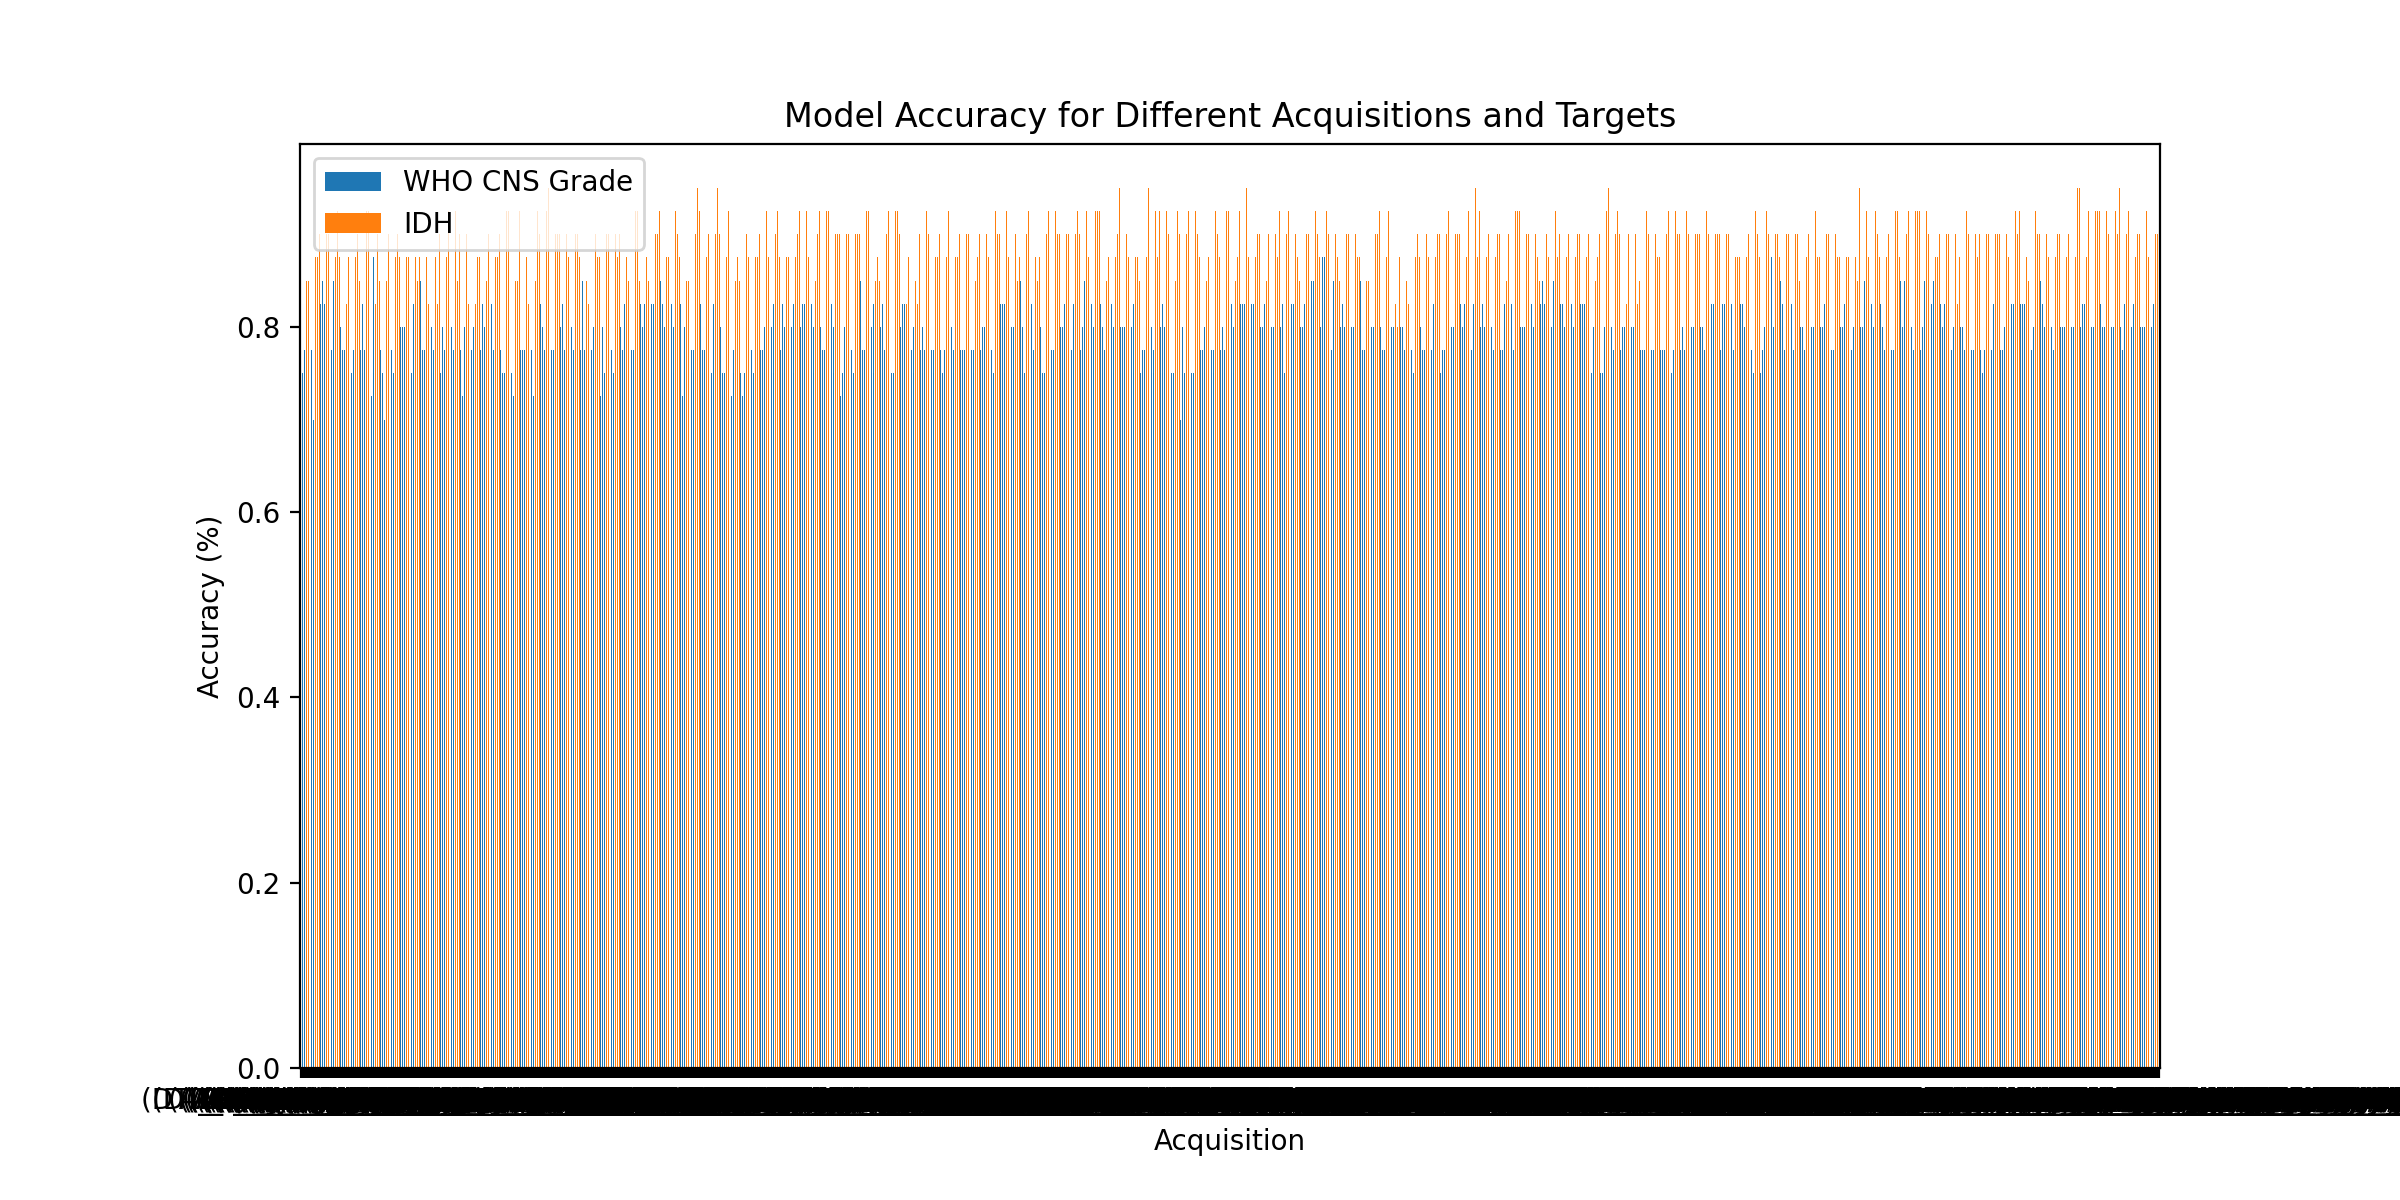

In [65]:
def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes

    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path, normalize=False):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace("extracted_firstorder_features_", "").replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_merged_data = train_merged_data.drop(106)    
    
    if normalize:
        columns_to_exclude = ['ID', 'Sex','WHO CNS Grade', 'IDH']
        train_merged_data = normalize_data(train_merged_data, columns_to_exclude)

    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes 
    
    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)

    if normalize:
        columns_to_exclude = ['ID', 'Sex','WHO CNS Grade', 'IDH']
        validation_merged_data = normalize_data(validation_merged_data, columns_to_exclude)
    
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    
    y_validation = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    
    return X_train, y_train, X_validation, y_validation

def normalize_data(df, columns_to_exclude):
    '''Andrew Ng suggests that gradient descent generally runs faster when features are rescaled, i.e. normalized and centred
    near 0. Although this is not necessarily relevant for XGBoost, which is a decision tree based method, 
    I add the normalization option here
    IMPORTANT: feature normalization decreased model performance with xgboost for Grade and IDH in this pipeline'''
    df_copy = df.copy()
    scaler = StandardScaler()
    for column in df_copy.columns:
        if column not in columns_to_exclude:
            df_copy[column] = scaler.fit_transform(df_copy[column].values.reshape(-1,1))
    return df_copy

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softmax",
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3, # has to be the value of the case with the most categories (here: WHO grades (3))
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = MultiOutputClassifier(xgb_clf)
    
    clf.fit(X_train, y_train)
    return clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def get_paths(base_directory, acquisitions):
    
    suffixes = [acquisition + ".csv" for acquisition in acquisitions]
    
    #print(f"Using {acquisitions} as model input")
    
    train_features_paths = [os.path.join(base_directory, "Training/extracted_features/extracted_firstorder_features_" + suffix) for suffix in suffixes]
    train_data_path = os.path.join(base_directory, "Training/train_data.csv")
    validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/extracted_firstorder_features_" + suffix) for suffix in suffixes]
    validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
    
    return train_features_paths, train_data_path, validation_features_paths, validation_data_path

def save_evaluation(acquisition, target_columns, y_validation, y_pred):
    # Save report of model performance to txt file
    output_directory = "/Users/Gabriel/Desktop/MSc_Dissertation/pyRadiomics/Model_performance"
    os.makedirs(output_directory, exist_ok=True)

    # Save report of model performance to txt file
    for i, col in enumerate(target_columns):
        report = classification_report(y_validation[col], y_pred[:, i])
        matrix = confusion_matrix(y_validation[col], y_pred[:, i])
        accuracy = accuracy_score(y_validation[col], y_pred[:, i])

        content = "Accuracy for {col}: {accuracy}\n\n".format(col=col, accuracy=accuracy)
        content += "Classification Report for {col}:\n{report}\n".format(col=col, report=report)
        content += "Confusion Matrix for {col}:\n{matrix}\n".format(col=col, matrix=matrix)

        file_name = acquisition[0] + "_{}_results.txt".format(col.replace('/', '_'))
        file_path = os.path.join(output_directory, file_name)
        with open(file_path, "w") as f:
            f.write(content)

def visualize_comparison(results_df):
    results_df.set_index("Acquisition", inplace=True)
    results_df.plot.bar(rot=0, figsize=(12, 6))
    plt.ylabel("Accuracy (%)")
    plt.title("Model Accuracy for Different Acquisitions and Targets")
    plt.show()
            
def main():
    base_directory = "/Users/Gabriel/Desktop/MSc_Dissertation/pyRadiomics/"

    # CHOOSE YOUR INPUT
    single_acquisitions = ["ADC", "DTI_eddy_FA", "FLAIR", "SWI", "DWI", "T1_contrast", "DTI_eddy_MD", "ASL", "T1", "T2"]

    results = []

    with tqdm(total=1023) as pbar:
        for r in range(1, len(single_acquisitions)+1):
            for acquisitions in combinations(single_acquisitions, r):
                # Get paths
                train_features_paths, train_data_path, validation_features_paths, validation_data_path = get_paths(base_directory, acquisitions)

                # Load data
                X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

                # Train the model
                clf = train_model(X_train, y_train)

                # Make predictions on the validation set
                y_pred = make_predictions(clf, X_validation)

                # Calculate and print the accuracy for each target column
                target_columns = ["WHO CNS Grade", "IDH"]
                accuracies = [accuracy_score(y_validation[col], y_pred[:, i]) for i, col in enumerate(target_columns)]

                # Store the results
                results.append({"Acquisition": acquisitions, **dict(zip(target_columns, accuracies))})
                
                pbar.update()

    results_df = pd.DataFrame(results)

    # Visualize comparison
    # visualize_comparison(results_df) # visualization in separate block of code
    
    return results_df

results_df = main()

# if __name__ == "__main__":
#     main()


## Show top results

<IPython.core.display.Javascript object>


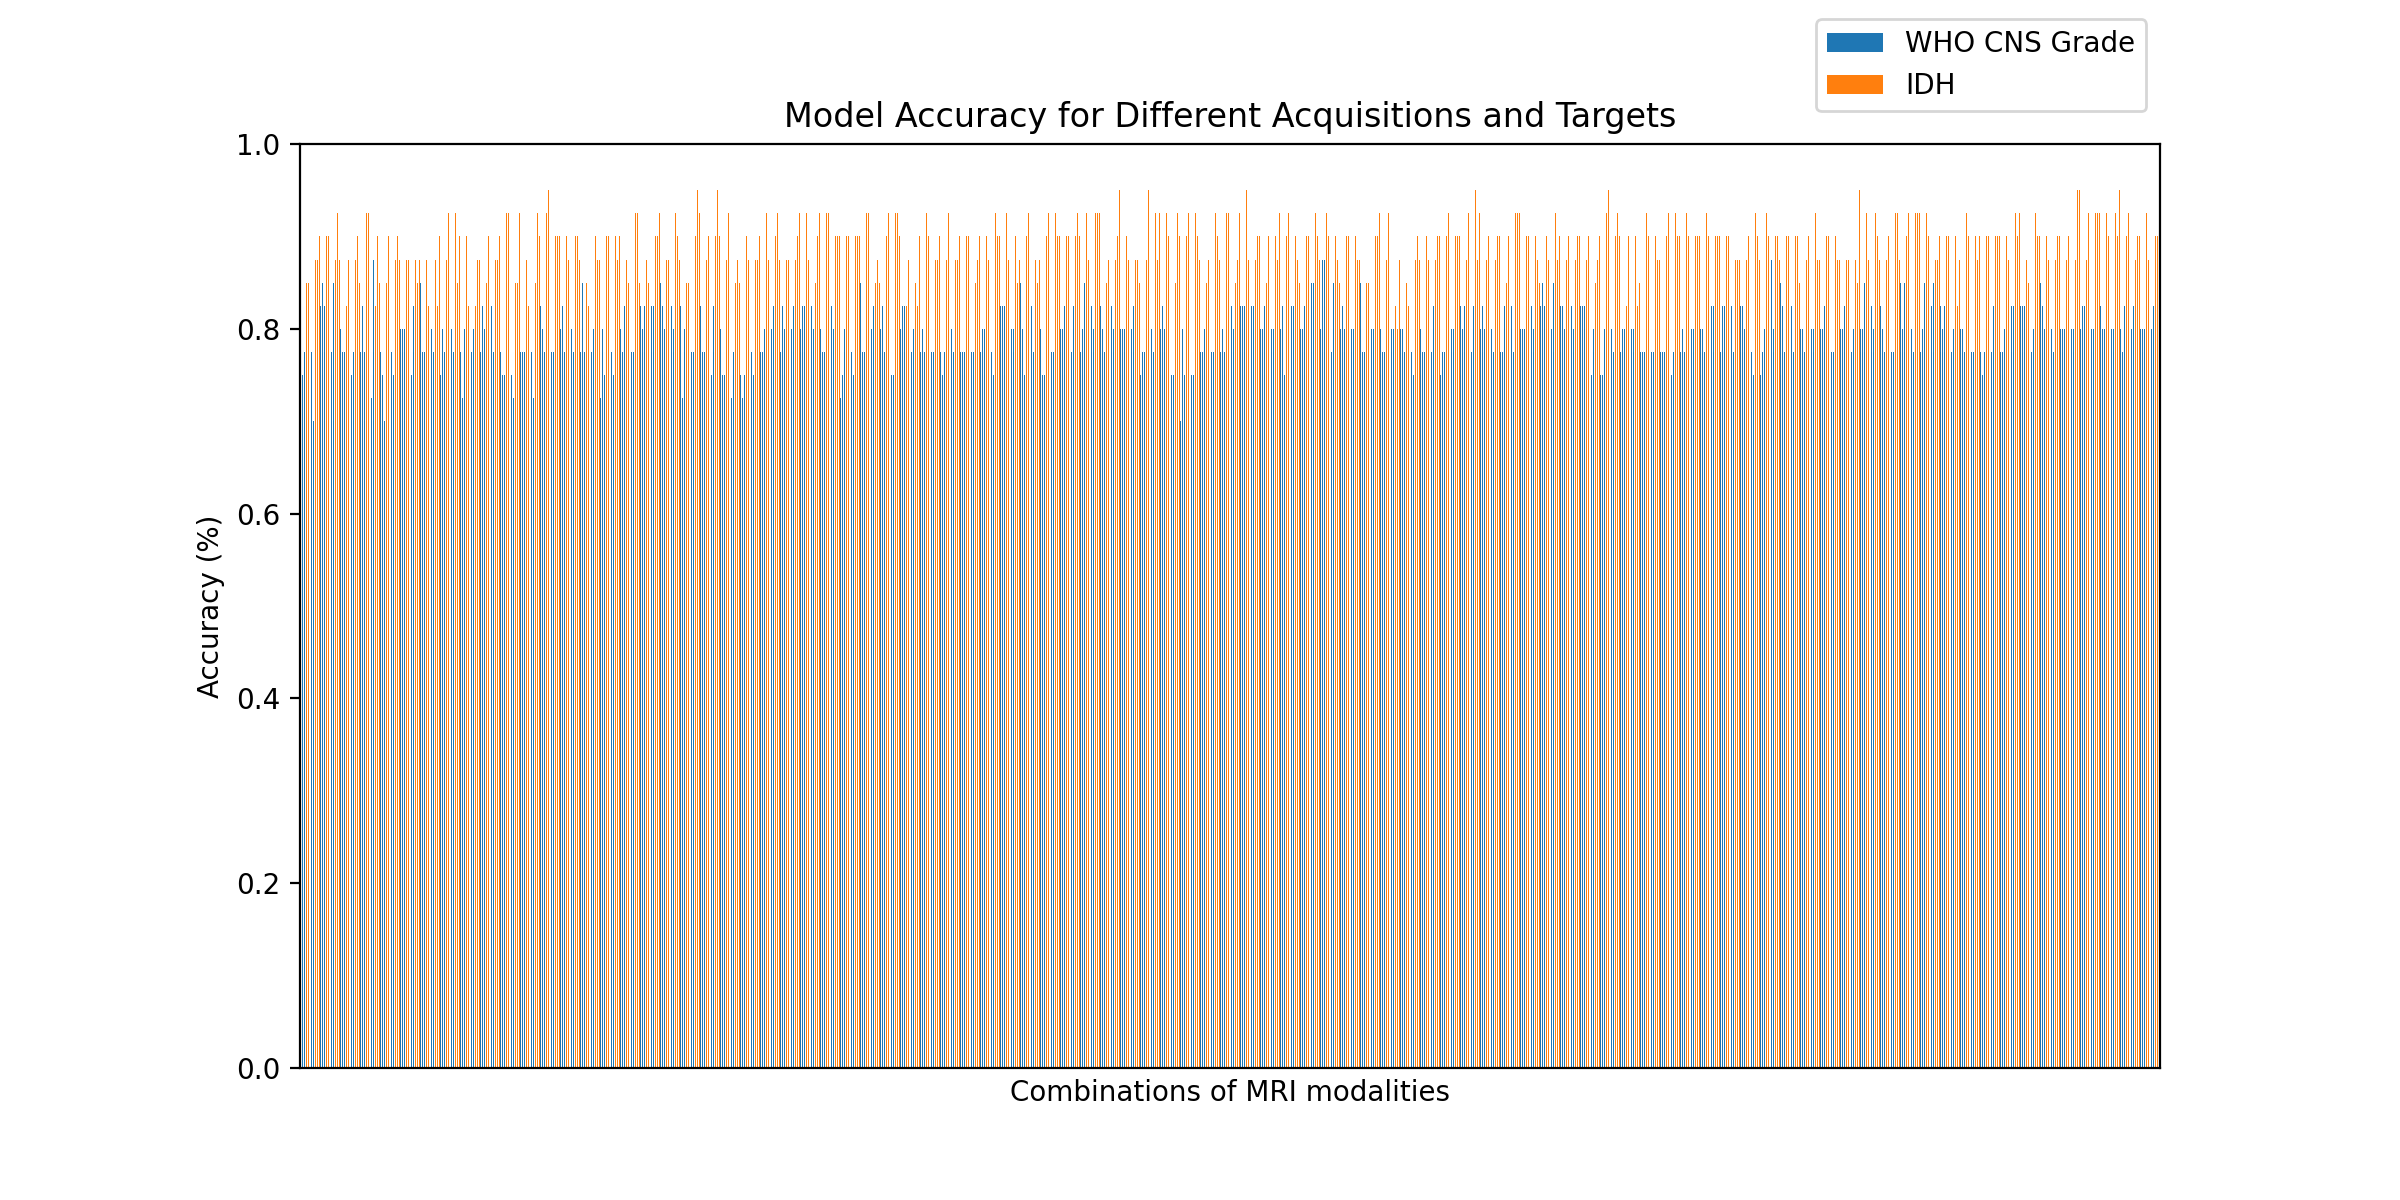

In [66]:
def visualize_comparison(results_df):

    # Plot the data
    ax = results_df.plot.bar(rot=0, figsize=(12, 6))
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1.15))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Combinations of MRI modalities")
    plt.title("Model Accuracy for Different Acquisitions and Targets")


    # Turn off the x-axis ticks and labels
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # Save the figure
    fig = ax.get_figure()
    fig.savefig("/Users/Gabriel/Desktop/accuracy_all_combinationsNORMALIZED.png", dpi=300)

# Call the function
visualize_comparison(results_df)


### Best modalities for WHO prediction

In [68]:
filtered_df = results_df[(results_df['WHO CNS Grade'] > 0.85)]
pd.set_option('display.max_colwidth', None)
filtered_df

,WHO CNS Grade,IDH
Acquisition,,
"(ADC,)",0.875,0.875
"(ADC, DTI_eddy_MD)",0.875,0.900
"(DWI, T1_contrast)",0.875,0.850
"(DTI_eddy_FA, T1_contrast, DTI_eddy_MD)",0.875,0.900
"(DTI_eddy_FA, SWI, DTI_eddy_MD, ASL, T1)",0.875,0.925
"(DTI_eddy_FA, SWI, DTI_eddy_MD, ASL, T2)",0.875,0.900
"(ADC, DTI_eddy_FA, FLAIR, DWI, T1_contrast, T1)",0.875,0.875
"(DTI_eddy_FA, SWI, T1_contrast, DTI_eddy_MD, ASL, T2)",0.875,0.925


### Best modalities for IDH prediction

In [71]:
filtered_df = results_df[(results_df['IDH'] > 0.94)]
pd.set_option('display.max_colwidth', None)
filtered_df

,WHO CNS Grade,IDH
Acquisition,,
"(FLAIR, DTI_eddy_MD, T2)",0.775,0.95
"(ADC, DTI_eddy_FA, FLAIR, DTI_eddy_MD)",0.825,0.95
"(ADC, FLAIR, DTI_eddy_MD, ASL)",0.775,0.95
"(ADC, SWI, T1_contrast, DTI_eddy_MD)",0.800,0.95
"(FLAIR, SWI, T1_contrast, DTI_eddy_MD)",0.825,0.95
"(FLAIR, DTI_eddy_MD, ASL, T2)",0.775,0.95
"(ADC, FLAIR, SWI, T1_contrast, DTI_eddy_MD)",0.825,0.95
"(ADC, FLAIR, SWI, DTI_eddy_MD, ASL)",0.775,0.95
"(ADC, FLAIR, T1_contrast, DTI_eddy_MD, ASL)",0.775,0.95


### Best modalities for overall prediction

In [72]:
top = results_df.assign(sum=results_df['WHO CNS Grade'] + results_df['IDH']).nlargest(10, 'sum')
top

,WHO CNS Grade,IDH,sum
Acquisition,,,
"(DTI_eddy_FA, SWI, DTI_eddy_MD, ASL, T1)",0.875,0.925,1.800
"(DTI_eddy_FA, SWI, T1_contrast, DTI_eddy_MD, ASL, T2)",0.875,0.925,1.800
"(ADC, DTI_eddy_FA, FLAIR, SWI, DTI_eddy_MD, ASL)",0.850,0.950,1.800
"(ADC, DTI_eddy_MD)",0.875,0.900,1.775
"(ADC, FLAIR, DTI_eddy_MD)",0.850,0.925,1.775
"(DTI_eddy_FA, T1_contrast, DTI_eddy_MD)",0.875,0.900,1.775
"(ADC, DTI_eddy_FA, FLAIR, DTI_eddy_MD)",0.825,0.950,1.775
"(FLAIR, SWI, T1_contrast, DTI_eddy_MD)",0.825,0.950,1.775
"(ADC, DTI_eddy_FA, T1_contrast, DTI_eddy_MD, T1)",0.850,0.925,1.775


### Single modalities as inputs perform just as well

Using ADC as model input
Confusion Matrix for WHO CNS Grade:
[[ 4  1  0]
 [ 1  1  3]
 [ 0  0 30]]

Confusion Matrix for IDH:
[[ 8  3]
 [ 2 27]]

Using DTI_eddy_FA as model input
Confusion Matrix for WHO CNS Grade:
[[ 2  3  0]
 [ 2  0  3]
 [ 0  2 28]]

Confusion Matrix for IDH:
[[ 8  3]
 [ 1 28]]

Using FLAIR as model input
Confusion Matrix for WHO CNS Grade:
[[ 2  1  2]
 [ 1  0  4]
 [ 1  0 29]]

Confusion Matrix for IDH:
[[ 5  6]
 [ 1 28]]

Using SWI as model input
Confusion Matrix for WHO CNS Grade:
[[ 0  3  2]
 [ 1  0  4]
 [ 0  1 29]]

Confusion Matrix for IDH:
[[ 7  4]
 [ 2 27]]

Using DWI as model input
Confusion Matrix for WHO CNS Grade:
[[ 3  0  2]
 [ 1  1  3]
 [ 2  0 28]]

Confusion Matrix for IDH:
[[ 7  4]
 [ 2 27]]

Using T1_contrast as model input
Confusion Matrix for WHO CNS Grade:
[[ 2  1  2]
 [ 1  1  3]
 [ 3  0 27]]

Confusion Matrix for IDH:
[[ 9  2]
 [ 2 27]]

Using DTI_eddy_MD as model input
Confusion Matrix for WHO CNS Grade:
[[ 3  0  2]
 [ 0  1  4]
 [ 2  1 27]]

Confu

<IPython.core.display.Javascript object>


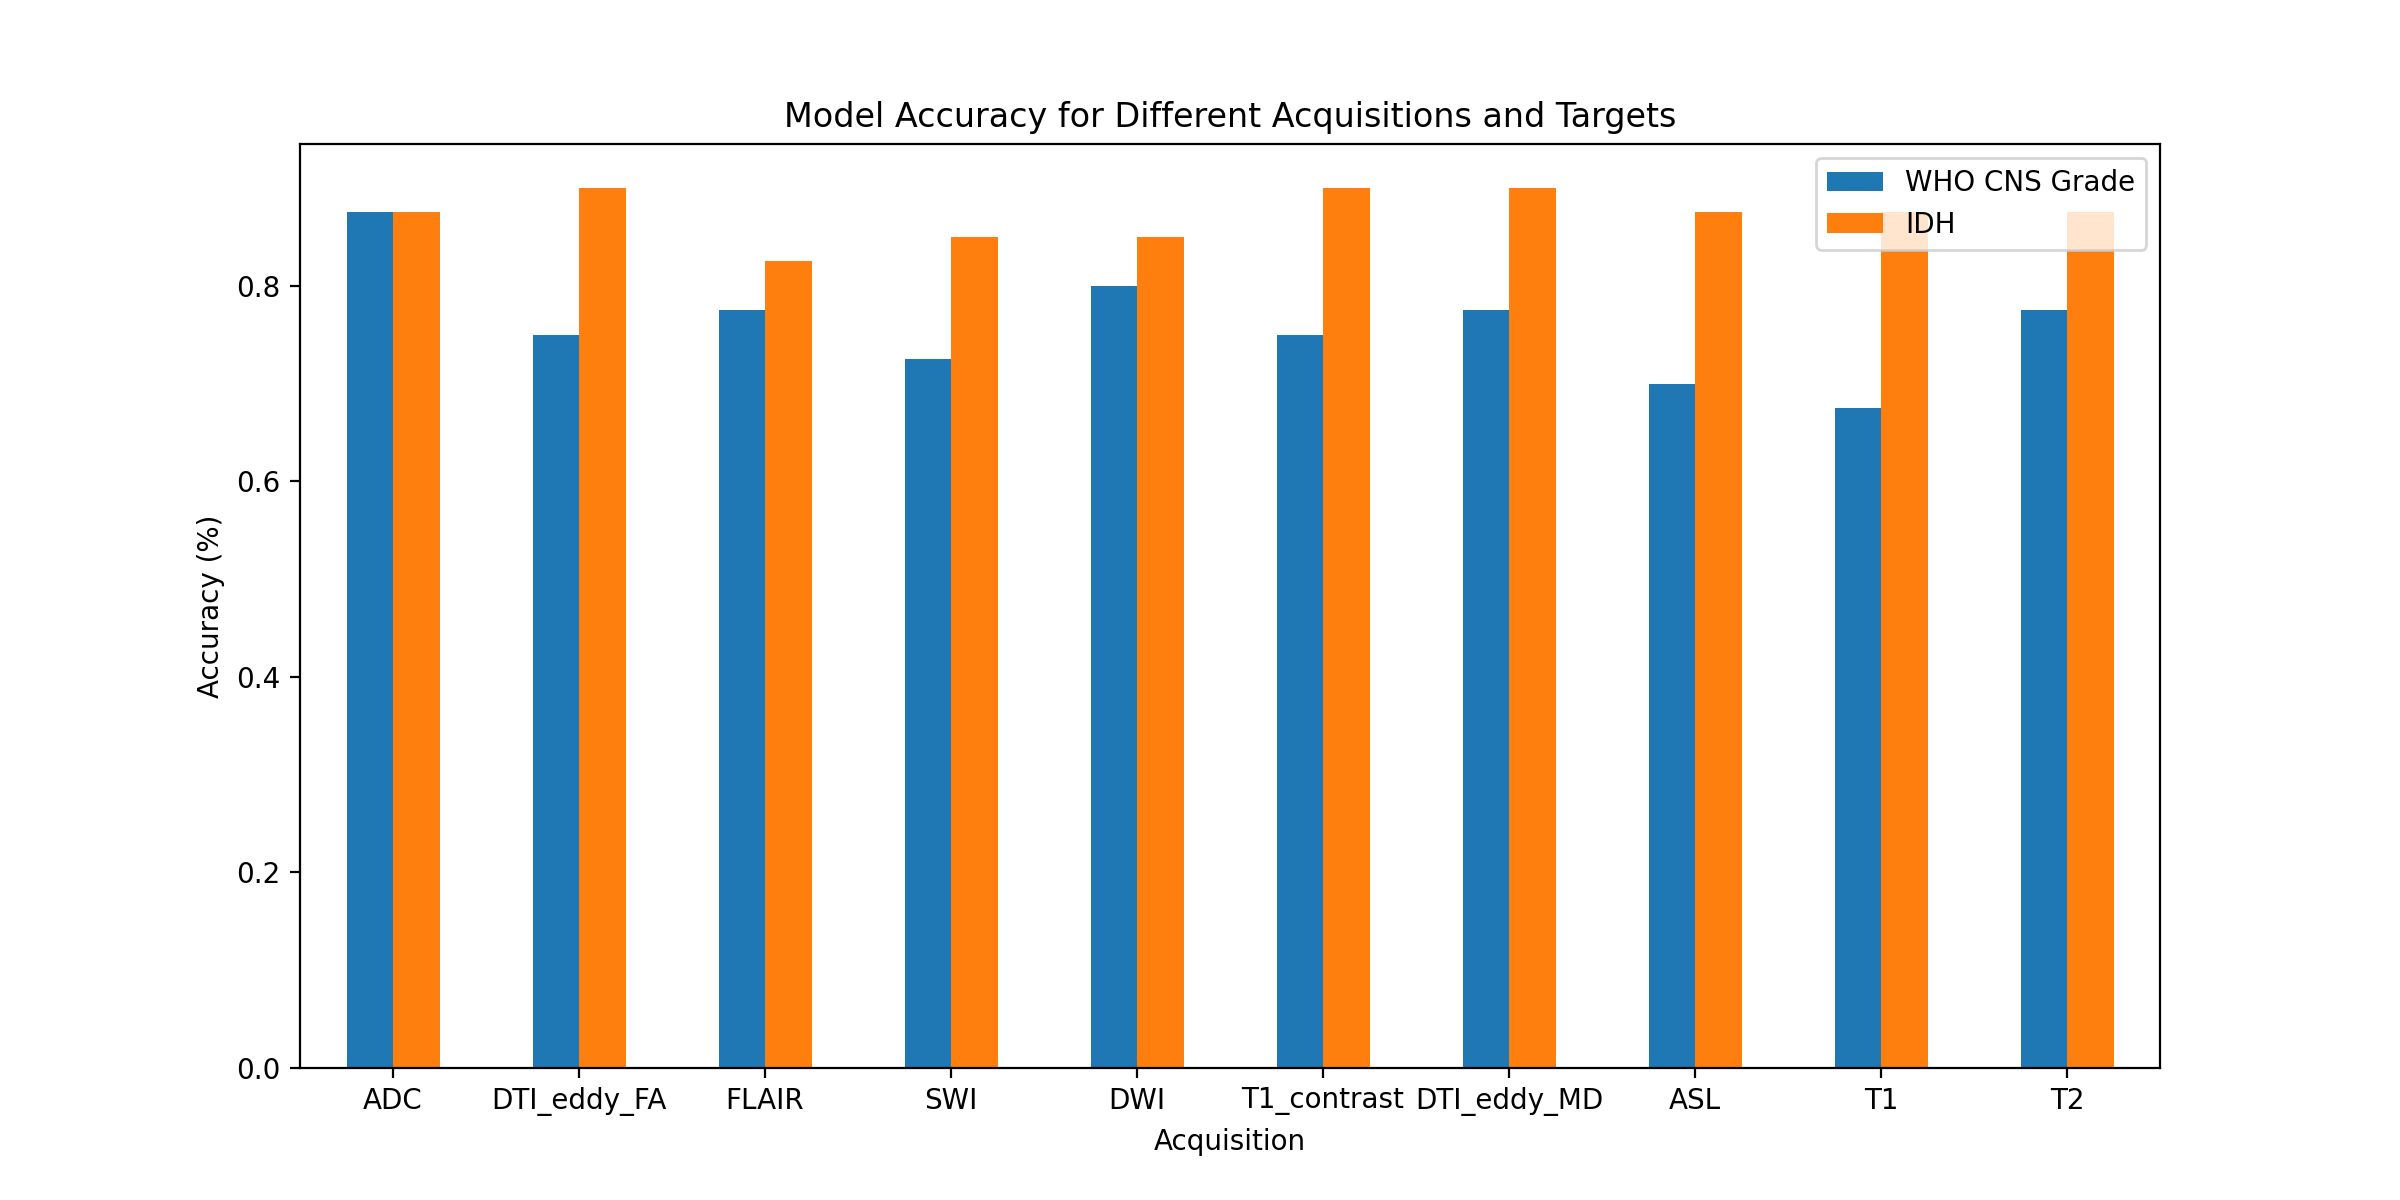

In [51]:
def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH and Sex column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes

    return df


def load_data(train_features_path, train_data_path,validation_features_path, validation_path, normalize=False):
    # Load data training 
    train_features_data = pd.read_csv(train_features_path).rename(columns={pd.read_csv(train_features_path).columns[0]: "ID"})
    train_features_data = train_features_data.astype(float)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    
    train_merged_data = train_meta_data[['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, on='ID', how='inner')
    train_merged_data = train_merged_data[train_merged_data['ID'] != 106] # drop patient 106 due to nan value 

    if normalize:
        columns_to_exclude = ['ID', 'Sex','WHO CNS Grade', 'IDH']
        train_merged_data = normalize_data(train_merged_data, columns_to_exclude)
    
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes 
    X_train = X_train.drop("ID", axis=1)  # Add this line to drop the 'ID' column from X_train
    
    
    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.read_csv(validation_features_path).rename(columns={pd.read_csv(validation_features_path).columns[0]: "ID"})
    validation_features_data = validation_features_data.astype(float)
    validation_meta_data = pd.read_csv(validation_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    
    validation_merged_data = validation_meta_data[['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, on='ID', how='inner')

    if normalize:
        columns_to_exclude = ['ID', 'Sex','WHO CNS Grade', 'IDH']
        validation_merged_data = normalize_data(validation_merged_data, columns_to_exclude)
    
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    X_validation = X_validation.drop("ID", axis=1)  # Add this line to drop the 'ID' column from X_validation
    
    y_validation = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])

    return X_train, y_train, X_validation, y_validation

def normalize_data(df, columns_to_exclude):
    '''Andrew Ng suggests that gradient descent generally runs faster when features are rescaled, i.e. normalized and centred
    near 0. Although this is not necessarily relevant for XGBoost, which is a decision tree based method, 
    I add the normalization option here'''
    df_copy = df.copy()
    scaler = StandardScaler()
    for column in df_copy.columns:
        if column not in columns_to_exclude:
            df_copy[column] = scaler.fit_transform(df_copy[column].values.reshape(-1,1))
    return df_copy

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softmax",
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3, # has to be the value of the case with the most categories (here: WHO grades (3))
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = MultiOutputClassifier(xgb_clf)
    
    clf.fit(X_train, y_train)
    return clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def get_paths(base_directory, acquisition):
    
    suffix = acquisition + ".csv"
    
    print(f"Using {acquisition} as model input")
    
    train_features_path = os.path.join(base_directory, "Training/extracted_features/extracted_firstorder_features_" + suffix)
    train_data_path = os.path.join(base_directory, "Training/train_data.csv")
    validation_features_path = os.path.join(base_directory, "Validation/extracted_features/extracted_firstorder_features_" + suffix)
    validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
    
    return train_features_path, train_data_path,validation_features_path, validation_data_path

def save_evaluation(acquisition, target_columns, y_validation, y_pred):
    # Save report of model performance to txt file
    output_directory = "/Users/Gabriel/Desktop/MSc_Dissertation/pyRadiomics/Model_performance"
    os.makedirs(output_directory, exist_ok=True)

    # Save report of model performance to txt file
    for i, col in enumerate(target_columns):
        report = classification_report(y_validation[col], y_pred[:, i])
        matrix = confusion_matrix(y_validation[col], y_pred[:, i])
        accuracy = accuracy_score(y_validation[col], y_pred[:, i])

        content = "Accuracy for {col}: {accuracy}\n\n".format(col=col, accuracy=accuracy)
        content += "Classification Report for {col}:\n{report}\n".format(col=col, report=report)
        content += "Confusion Matrix for {col}:\n{matrix}\n".format(col=col, matrix=matrix)

        file_name = acquisition[0] + "_{}_results.txt".format(col.replace('/', '_'))
        file_path = os.path.join(output_directory, file_name)
        with open(file_path, "w") as f:
            f.write(content)

def visualize_comparison(results_df):
    results_df.set_index("Acquisition", inplace=True)
    results_df.plot.bar(rot=0, figsize=(12, 6))
    plt.ylabel("Accuracy (%)")
    plt.title("Model Accuracy for Different Acquisitions and Targets")
    plt.show()
            
def main():
    base_directory = "/Users/Gabriel/Desktop/MSc_Dissertation/pyRadiomics/"
    
    # CHOOSE YOUR INPUT
    acquisitions = ["ADC", "DTI_eddy_FA", "FLAIR", "SWI", "DWI", "T1_contrast", "DTI_eddy_MD", "ASL", "T1", "T2"]

    results = []

    for acquisition in acquisitions:
        # Get paths
        train_features_path, train_data_path,validation_features_path, validation_data_path = get_paths(base_directory,acquisition)

        # Load data
        X_train, y_train, X_validation, y_validation = load_data(train_features_path, train_data_path,validation_features_path, validation_data_path)

        # Train the model
        clf = train_model(X_train, y_train)

        # Make predictions on the validation set
        y_pred = make_predictions(clf, X_validation)

        # Calculate and print the accuracy for each target column
        target_columns = ["WHO CNS Grade", "IDH"]
        accuracies = [accuracy_score(y_validation[col], y_pred[:, i]) for i, col in enumerate(target_columns)]

        # Store the results
        results.append({"Acquisition": acquisition, **dict(zip(target_columns, accuracies))})

        # Print confusion matrices for each target column
        for i, col in enumerate(y_train.columns):
            matrix = confusion_matrix(y_validation[col], y_pred[:, i])
            print(f"Confusion Matrix for {col}:\n{matrix}\n")

    results_df = pd.DataFrame(results)
    print(results_df)

    # Visualize comparison
    visualize_comparison(results_df)

            
if __name__ == "__main__":
    main()